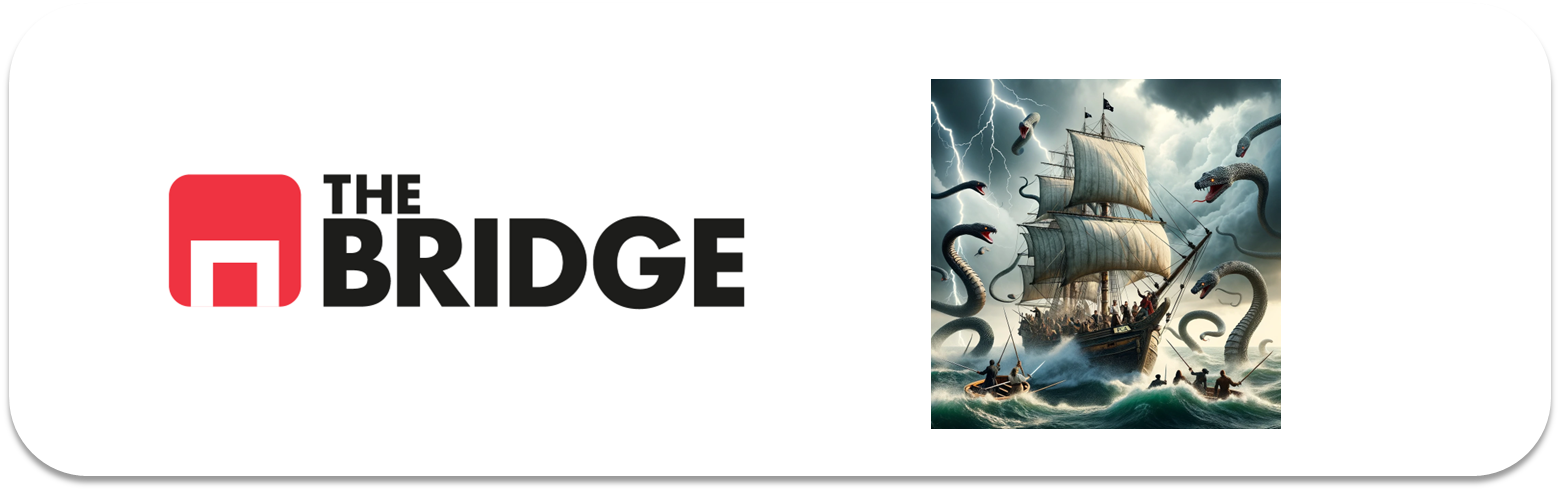

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import (
    SelectKBest, f_classif, mutual_info_classif,
    SelectFromModel, RFE, SequentialFeatureSelector
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix,
    recall_score, roc_auc_score, roc_curve, make_scorer
)
from sklearn.model_selection import GridSearchCV
from collections import Counter

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [2]:
df = pd.read_csv('data/credit_npo.csv')
print('Shape original:', df.shape)
print()
print('Nulos por columna:')
print(df.isnull().sum())
print()
print('Balance de clases:')
print(df['SeriousDlqin2yrs'].value_counts(normalize=True).round(4))

Shape original: (12537, 11)

Nulos por columna:
SeriousDlqin2yrs                          0
RevolvingUtilizationOfUnsecuredLines      0
age                                       0
NumberOfTime30-59DaysPastDueNotWorse      0
DebtRatio                                 0
MonthlyIncome                           721
NumberOfOpenCreditLinesAndLoans           0
NumberOfTimes90DaysLate                   0
NumberRealEstateLoansOrLines              0
NumberOfTime60-89DaysPastDueNotWorse      0
NumberOfDependents                      177
dtype: int64

Balance de clases:
SeriousDlqin2yrs
0    0.9311
1    0.0689
Name: proportion, dtype: float64


In [3]:
# Eliminar nulos
df = df.dropna()
print('Shape tras dropna:', df.shape)

# ── Convertir NumberOf... a categóricas ──
late_cols = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfTimes90DaysLate'
]
for col in late_cols:
    df[col + '_cat'] = pd.cut(df[col],
                               bins=[-1, 0, 1, df[col].max()+1],
                               labels=['0', '1', '2+'])

df['CreditLines_cat'] = pd.cut(df['NumberOfOpenCreditLinesAndLoans'],
    bins=[-1, 5, 12, df['NumberOfOpenCreditLinesAndLoans'].max()+1],
    labels=['bajo', 'medio', 'alto'])

df['RealEstate_cat'] = pd.cut(df['NumberRealEstateLoansOrLines'],
    bins=[-1, 0, 1, df['NumberRealEstateLoansOrLines'].max()+1],
    labels=['0', '1', '2+'])

df['Dependents_cat'] = pd.cut(df['NumberOfDependents'],
    bins=[-1, 0, 2, df['NumberOfDependents'].max()+1],
    labels=['0', '1-2', '3+'])

cat_cols_new = [c for c in df.columns if c.endswith('_cat')]
print('Nuevas categóricas:', cat_cols_new)

Shape tras dropna: (11816, 11)
Nuevas categóricas: ['NumberOfTime30-59DaysPastDueNotWorse_cat', 'NumberOfTime60-89DaysPastDueNotWorse_cat', 'NumberOfTimes90DaysLate_cat', 'CreditLines_cat', 'RealEstate_cat', 'Dependents_cat']


In [5]:
# Preparar X e y
TARGET = 'SeriousDlqin2yrs'
num_original_keep = ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']
drop_num = ['NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse',
            'NumberOfTimes90DaysLate', 'NumberOfOpenCreditLinesAndLoans',
            'NumberRealEstateLoansOrLines', 'NumberOfDependents']

df_enc = pd.get_dummies(df, columns=cat_cols_new, drop_first=True)
feature_cols = [c for c in df_enc.columns if c != TARGET and c not in drop_num]

X = df_enc[feature_cols].astype(float)
y = df_enc[TARGET]

print('Features finales:', feature_cols)
print('Total:', len(feature_cols))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_sc  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns,  index=X_test.index)
print(f'Train: {X_train.shape} | Test: {X_test.shape}')

Features finales: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfTime30-59DaysPastDueNotWorse_cat_1', 'NumberOfTime30-59DaysPastDueNotWorse_cat_2+', 'NumberOfTime60-89DaysPastDueNotWorse_cat_1', 'NumberOfTime60-89DaysPastDueNotWorse_cat_2+', 'NumberOfTimes90DaysLate_cat_1', 'NumberOfTimes90DaysLate_cat_2+', 'CreditLines_cat_medio', 'CreditLines_cat_alto', 'RealEstate_cat_1', 'RealEstate_cat_2+', 'Dependents_cat_1-2', 'Dependents_cat_3+']
Total: 16
Train: (9452, 16) | Test: (2364, 16)


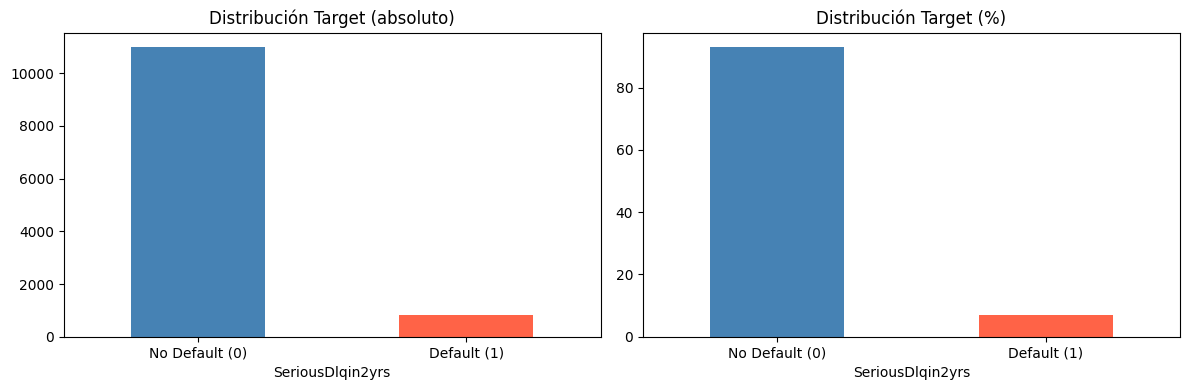

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
y.value_counts().plot(kind='bar', ax=axes[0], color=['steelblue','tomato'])
axes[0].set_title('Distribución Target (absoluto)')
axes[0].set_xticklabels(['No Default (0)', 'Default (1)'], rotation=0)
y.value_counts(normalize=True).mul(100).plot(kind='bar', ax=axes[1], color=['steelblue','tomato'])
axes[1].set_title('Distribución Target (%)')
axes[1].set_xticklabels(['No Default (0)', 'Default (1)'], rotation=0)
plt.tight_layout()
plt.show()
# Dataset desbalanceado: ~93% no default, ~7% default
# Usaremos class_weight='balanced' y recall como métrica principal

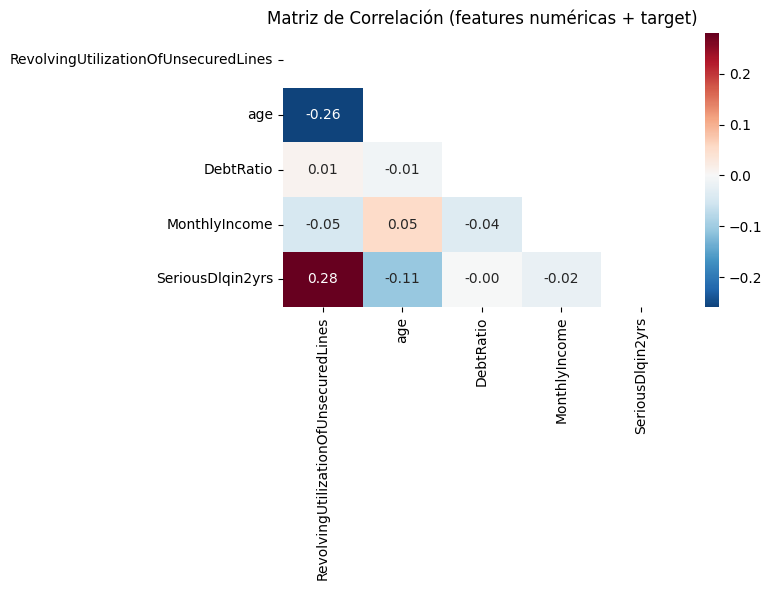

Correlación |r| con SeriousDlqin2yrs:
RevolvingUtilizationOfUnsecuredLines    0.280350
age                                     0.106076
MonthlyIncome                           0.022199
DebtRatio                               0.001666
Name: SeriousDlqin2yrs, dtype: float64


In [7]:
num_for_corr = num_original_keep + [TARGET]
corr = df[num_for_corr].corr()

fig, ax = plt.subplots(figsize=(8, 6))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', center=0, ax=ax)
ax.set_title('Matriz de Correlación (features numéricas + target)')
plt.tight_layout()
plt.show()

corr_target = corr[TARGET].drop(TARGET).abs().sort_values(ascending=False)
print('Correlación |r| con SeriousDlqin2yrs:')
print(corr_target)

In [9]:
# MI sobre todas las features para completar el análisis de Lista 1
mi_all = mutual_info_classif(X_train, y_train, discrete_features='auto', random_state=42)
mi_series = pd.Series(mi_all, index=X_train.columns).sort_values(ascending=False)
print('Mutual Information (ranking):')
print(mi_series.round(5))

# Sin features con alta correlación mutua entre sí (>0.85)
corr_feat = df[num_original_keep].corr().abs()
upper = corr_feat.where(np.triu(np.ones(corr_feat.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.85)]
print('\nFeatures redundantes (correlación mutua > 0.85):', to_drop)

lista_1 = mi_series[~mi_series.index.isin(to_drop)].nlargest(6).index.tolist()
print('\n>>> LISTA 1:', lista_1)

Mutual Information (ranking):
RevolvingUtilizationOfUnsecuredLines           0.04180
NumberOfTimes90DaysLate_cat_2+                 0.02791
NumberOfTime30-59DaysPastDueNotWorse_cat_2+    0.01648
NumberOfTimes90DaysLate_cat_1                  0.01064
NumberOfTime60-89DaysPastDueNotWorse_cat_1     0.01008
NumberOfTime60-89DaysPastDueNotWorse_cat_2+    0.00843
age                                            0.00664
NumberOfTime30-59DaysPastDueNotWorse_cat_1     0.00608
CreditLines_cat_alto                           0.00284
Dependents_cat_1-2                             0.00143
DebtRatio                                      0.00051
MonthlyIncome                                  0.00034
RealEstate_cat_1                               0.00000
CreditLines_cat_medio                          0.00000
RealEstate_cat_2+                              0.00000
Dependents_cat_3+                              0.00000
dtype: float64

Features redundantes (correlación mutua > 0.85): []

>>> LISTA 1: ['Revolv

In [10]:
num_cols_tr = num_original_keep
cat_cols_tr  = [c for c in X_train.columns if c not in num_cols_tr]

# ANOVA para numéricas
skb = SelectKBest(f_classif, k=4)
skb.fit(X_train[num_cols_tr], y_train)
f_scores = pd.Series(skb.scores_, index=num_cols_tr).sort_values(ascending=False)
print('F-scores ANOVA:')
print(f_scores.round(2))
best_num = f_scores.nlargest(3).index.tolist()

# MI para categóricas
mi_cat = mutual_info_classif(X_train[cat_cols_tr].astype(float), y_train,
                              discrete_features=True, random_state=42)
mi_cat_s = pd.Series(mi_cat, index=cat_cols_tr).sort_values(ascending=False)
print('\nMI categóricas:')
print(mi_cat_s.round(5))
best_cat = mi_cat_s.nlargest(3).index.tolist()

lista_2 = (best_num + best_cat)[:6]
print('\n>>> LISTA 2:', lista_2)

F-scores ANOVA:
RevolvingUtilizationOfUnsecuredLines    788.27
age                                     105.86
MonthlyIncome                             6.12
DebtRatio                                 0.00
dtype: float64

MI categóricas:
NumberOfTimes90DaysLate_cat_2+                 0.02350
NumberOfTime30-59DaysPastDueNotWorse_cat_2+    0.01505
NumberOfTimes90DaysLate_cat_1                  0.01008
NumberOfTime60-89DaysPastDueNotWorse_cat_1     0.01003
NumberOfTime60-89DaysPastDueNotWorse_cat_2+    0.00955
NumberOfTime30-59DaysPastDueNotWorse_cat_1     0.00531
RealEstate_cat_1                               0.00113
CreditLines_cat_medio                          0.00089
Dependents_cat_1-2                             0.00038
Dependents_cat_3+                              0.00033
CreditLines_cat_alto                           0.00002
RealEstate_cat_2+                              0.00000
dtype: float64

>>> LISTA 2: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'MonthlyIncome', 'NumberOfT

Feature importances RF:
RevolvingUtilizationOfUnsecuredLines           0.2771
DebtRatio                                      0.1467
age                                            0.1398
MonthlyIncome                                  0.1377
NumberOfTimes90DaysLate_cat_2+                 0.0566
NumberOfTime30-59DaysPastDueNotWorse_cat_2+    0.0527
NumberOfTime60-89DaysPastDueNotWorse_cat_1     0.0305
NumberOfTimes90DaysLate_cat_1                  0.0303
NumberOfTime30-59DaysPastDueNotWorse_cat_1     0.0255
Dependents_cat_1-2                             0.0189
CreditLines_cat_medio                          0.0157
NumberOfTime60-89DaysPastDueNotWorse_cat_2+    0.0157
RealEstate_cat_1                               0.0152
RealEstate_cat_2+                              0.0131
CreditLines_cat_alto                           0.0126
Dependents_cat_3+                              0.0118
dtype: float64


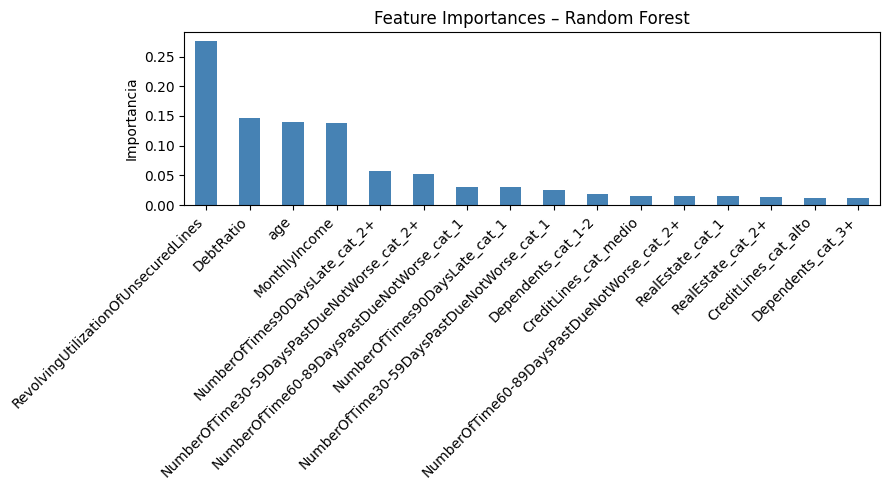


>>> LISTA 3: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome']


In [11]:
rf_sel = RandomForestClassifier(n_estimators=100, random_state=42,
                                 class_weight='balanced', n_jobs=-1)
rf_sel.fit(X_train, y_train)

importances = pd.Series(rf_sel.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('Feature importances RF:')
print(importances.round(4))

fig, ax = plt.subplots(figsize=(9, 5))
importances.plot(kind='bar', ax=ax, color='steelblue')
ax.set_title('Feature Importances – Random Forest')
ax.set_ylabel('Importancia')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

sfm = SelectFromModel(rf_sel, prefit=True, max_features=6)
lista_3 = X_train.columns[sfm.get_support()].tolist()
if len(lista_3) == 0 or len(lista_3) > 6:
    lista_3 = importances.nlargest(6).index.tolist()
print('\n>>> LISTA 3:', lista_3)

In [12]:
lr_rfe = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
rfe = RFE(estimator=lr_rfe, n_features_to_select=6, step=1)
rfe.fit(X_train_sc, y_train)

rfe_rank = pd.Series(rfe.ranking_, index=X_train.columns).sort_values()
print('RFE ranking (1 = seleccionada):')
print(rfe_rank)

lista_4 = X_train.columns[rfe.support_].tolist()
print('\n>>> LISTA 4:', lista_4)

RFE ranking (1 = seleccionada):
RevolvingUtilizationOfUnsecuredLines            1
age                                             1
NumberOfTime30-59DaysPastDueNotWorse_cat_2+     1
NumberOfTime30-59DaysPastDueNotWorse_cat_1      1
NumberOfTimes90DaysLate_cat_2+                  1
NumberOfTimes90DaysLate_cat_1                   1
RealEstate_cat_2+                               2
NumberOfTime60-89DaysPastDueNotWorse_cat_1      3
NumberOfTime60-89DaysPastDueNotWorse_cat_2+     4
MonthlyIncome                                   5
CreditLines_cat_alto                            6
CreditLines_cat_medio                           7
Dependents_cat_1-2                              8
RealEstate_cat_1                                9
Dependents_cat_3+                              10
DebtRatio                                      11
dtype: int64

>>> LISTA 4: ['RevolvingUtilizationOfUnsecuredLines', 'age', 'NumberOfTime30-59DaysPastDueNotWorse_cat_1', 'NumberOfTime30-59DaysPastDueNotWorse_cat_2+', 

In [14]:
lr_sfs = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
sfs = SequentialFeatureSelector(lr_sfs, n_features_to_select=6,
                                  direction='forward', scoring='recall', cv=3, n_jobs=-1)
sfs.fit(X_train_sc, y_train)

lista_5 = X_train.columns[sfs.get_support()].tolist()
print('>>> LISTA 5:', lista_5)

>>> LISTA 5: ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfTime30-59DaysPastDueNotWorse_cat_2+', 'NumberOfTime60-89DaysPastDueNotWorse_cat_2+', 'RealEstate_cat_1', 'Dependents_cat_3+']


In [15]:
all_selected = lista_1 + lista_2 + lista_3 + lista_4 + lista_5
votes = Counter(all_selected)
print('Votos por feature (sobre 5 posibles):')
for feat, cnt in votes.most_common():
    bar = '█' * cnt
    print(f'  {feat:<55} {bar} {cnt}/5')

lista_6 = [f for f, _ in votes.most_common(6)]
print('\n>>> LISTA 6 (Hard Voting):', lista_6)

Votos por feature (sobre 5 posibles):
  RevolvingUtilizationOfUnsecuredLines                    █████ 5/5
  NumberOfTime30-59DaysPastDueNotWorse_cat_2+             ████ 4/5
  NumberOfTimes90DaysLate_cat_2+                          ███ 3/5
  NumberOfTimes90DaysLate_cat_1                           ███ 3/5
  age                                                     ███ 3/5
  NumberOfTime60-89DaysPastDueNotWorse_cat_2+             ██ 2/5
  MonthlyIncome                                           ██ 2/5
  DebtRatio                                               ██ 2/5
  NumberOfTime60-89DaysPastDueNotWorse_cat_1              █ 1/5
  NumberOfTime30-59DaysPastDueNotWorse_cat_1              █ 1/5
  RealEstate_cat_1                                        █ 1/5
  Dependents_cat_3+                                       █ 1/5

>>> LISTA 6 (Hard Voting): ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse_cat_2+', 'NumberOfTimes90DaysLate_cat_2+', 'NumberOfTimes90DaysLate_cat

### Resumen de las 6 Listas
| # | Técnica | Features seleccionadas |
|---|---------|------------------------|
| 1 | Corr + Covarianza | RevolvUtil, 90DaysLate_2+, 30-59_2+, 90DaysLate_1, 60-89_1, 60-89_2+ |
| 2 | ANOVA + MI Cat | RevolvUtil, age, MonthlyIncome, DebtRatio, 90DaysLate_2+, 30-59_2+ |
| 3 | SelectFromModel RF | RevolvUtil, age, DebtRatio, MonthlyIncome |
| 4 | RFE (LR) | RevolvUtil, age, 30-59_1, 30-59_2+, 90DaysLate_1, 90DaysLate_2+ |
| 5 | SFS Forward | RevolvUtil, DebtRatio, 30-59_2+, 60-89_2+, RealEstate_1, Dependents_3+ |
| 6 | Hard Voting | RevolvUtil, 30-59_2+, 90DaysLate_2+, age, DebtRatio, 90DaysLate_1 |

**`RevolvingUtilizationOfUnsecuredLines`** aparece en las **5/5 listas** — es sin duda la feature más importante.

## 3. Comparación: 3 Modelos × 6 Listas = 18 Combinaciones

**Métrica:** Recall de la clase positiva (Default=1).  
Dado el fuerte desbalance (~7% defaults), el recall es más informativo que accuracy.  
Usamos CV-5 estratificado. `class_weight='balanced'` en todos los modelos que lo soporten.

In [18]:
listas = {
    'Lista 1 (Corr+Cov)':          lista_1,
    'Lista 2 (ANOVA+MI)':           lista_2,
    'Lista 3 (SelectFromModel RF)': lista_3,
    'Lista 4 (RFE LR)':             lista_4,
    'Lista 5 (SFS Forward)':        lista_5,
    'Lista 6 (Hard Voting)':        lista_6,
}

models = {
    'Logistic Regression':  LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'Random Forest':        RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state= 42, n_jobs=-1),
    'Gradient Boosting':    GradientBoostingClassifier(n_estimators=100, random_state= 42),
}

cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state= 42)
scorer = make_scorer(recall_score, pos_label=1)

results = []
for lista_name, feat_list in listas.items():
    for model_name, model in models.items():
        Xtr = X_train_sc[feat_list] if 'Logistic' in model_name else X_train[feat_list]
        scores = cross_val_score(model, Xtr, y_train, cv=cv5, scoring=scorer, n_jobs=-1)
        results.append({'Lista': lista_name, 'Modelo': model_name,
                        'Recall_mean': scores.mean(), 'Recall_std': scores.std()})

results_df = pd.DataFrame(results)
pivot = results_df.pivot(index='Lista', columns='Modelo', values='Recall_mean')
print('=== RECALL MEDIO (CV-5) ===')
print(pivot.round(4).to_string())

=== RECALL MEDIO (CV-5) ===
Modelo                        Gradient Boosting  Logistic Regression  Random Forest
Lista                                                                              
Lista 1 (Corr+Cov)                       0.2094               0.7199         0.3283
Lista 2 (ANOVA+MI)                       0.2004               0.7184         0.1822
Lista 3 (SelectFromModel RF)             0.0407               0.7183         0.0362
Lista 4 (RFE LR)                         0.2199               0.7184         0.2500
Lista 5 (SFS Forward)                    0.0979               0.7380         0.1476
Lista 6 (Hard Voting)                    0.2124               0.7184         0.2304


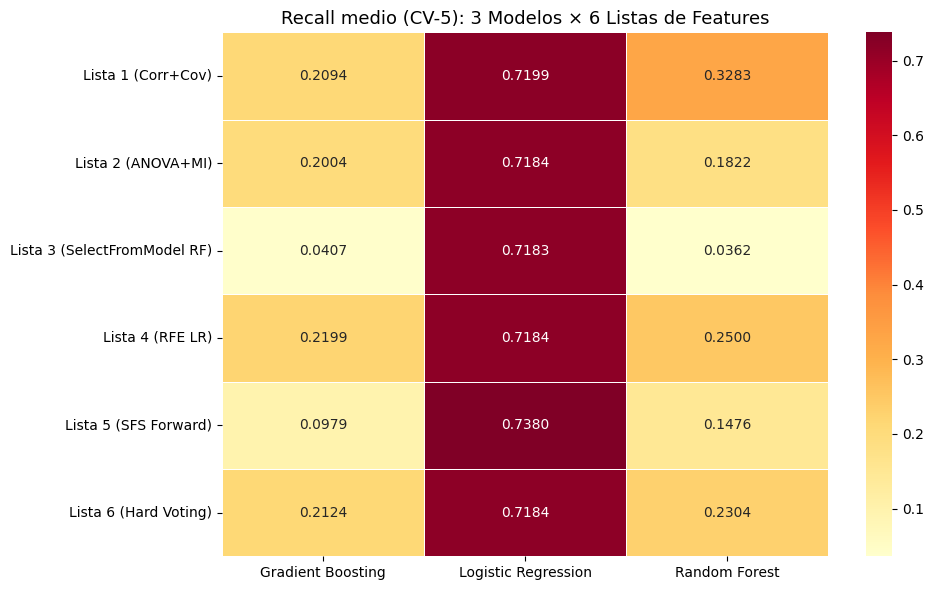


 MEJOR COMBINACIÓN: Logistic Regression + Lista 5 (SFS Forward)
  Recall CV-5 = 0.7380 ± 0.0183
  Features: ['RevolvingUtilizationOfUnsecuredLines', 'DebtRatio', 'NumberOfTime30-59DaysPastDueNotWorse_cat_2+', 'NumberOfTime60-89DaysPastDueNotWorse_cat_2+', 'RealEstate_cat_1', 'Dependents_cat_3+']

Conclusión: Logistic Regression domina en todas las listas porque el dataset
es linealmente separable con estas features y el recall requiere clase balanceada.


In [19]:
# Heatmap
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlOrRd', ax=ax,
            linewidths=0.5, linecolor='white')
ax.set_title('Recall medio (CV-5): 3 Modelos × 6 Listas de Features', fontsize=13)
ax.set_xlabel('')
ax.set_ylabel('')
plt.tight_layout()
plt.show()

best = results_df.loc[results_df['Recall_mean'].idxmax()]
print(f"\n MEJOR COMBINACIÓN: {best['Modelo']} + {best['Lista']}")
print(f"  Recall CV-5 = {best['Recall_mean']:.4f} ± {best['Recall_std']:.4f}")
print(f"  Features: {listas[best['Lista']]}")
print()
print('Conclusión: Logistic Regression domina en todas las listas porque el dataset')
print('es linealmente separable con estas features y el recall requiere clase balanceada.')


## 4. Optimización de Hiperparámetros

**Mejor combinación:** Logistic Regression + Lista 5 (SFS Forward)  
**Features:** `RevolvingUtilizationOfUnsecuredLines`, `DebtRatio`, `NumberOfTime30-59_2+`, `NumberOfTime60-89_2+`, `RealEstate_1`, `Dependents_3+`  

Grid search con CV-5, optimizando recall.

In [20]:
BEST_FEATURES = listas['Lista 5 (SFS Forward)']

param_grid = {
    'C':             [0.01, 0.1, 1, 10, 100],
    'penalty':       ['l1', 'l2'],
    'solver':        ['saga'],
    'max_iter':      [2000],
    'class_weight':  ['balanced'],
}

gs = GridSearchCV(LogisticRegression(random_state=42), param_grid,
                  scoring='recall', cv=cv5, n_jobs=-1, verbose=0)
gs.fit(X_train_sc[BEST_FEATURES], y_train)

print('Mejores hiperparámetros:', gs.best_params_)
print(f'Recall CV (train): {gs.best_score_:.4f}')

Mejores hiperparámetros: {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 2000, 'penalty': 'l1', 'solver': 'saga'}
Recall CV (train): 0.7395


In [21]:
# Evaluación en TEST
best_model = gs.best_estimator_
y_pred  = best_model.predict(X_test_sc[BEST_FEATURES])
y_proba = best_model.predict_proba(X_test_sc[BEST_FEATURES])[:, 1]

print('=== EVALUACIÓN EN TEST ===')
print(classification_report(y_test, y_pred, target_names=['No Default', 'Default']))
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print(f'ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}')

=== EVALUACIÓN EN TEST ===
              precision    recall  f1-score   support

  No Default       0.98      0.77      0.86      2198
     Default       0.20      0.75      0.31       166

    accuracy                           0.77      2364
   macro avg       0.59      0.76      0.59      2364
weighted avg       0.92      0.77      0.82      2364

Confusion Matrix:
[[1696  502]
 [  42  124]]
ROC-AUC: 0.8172


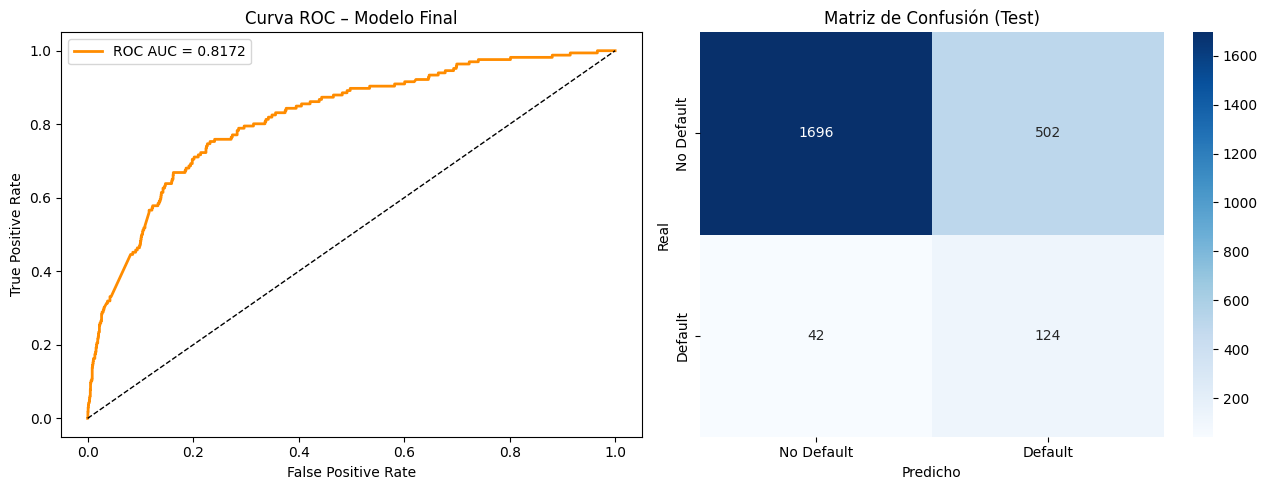

In [22]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC AUC = {roc_auc_score(y_test, y_proba):.4f}')
axes[0].plot([0,1],[0,1], 'k--', lw=1)
axes[0].set_xlabel('False Positive Rate')
axes[0].set_ylabel('True Positive Rate')
axes[0].set_title('Curva ROC – Modelo Final')
axes[0].legend()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['No Default','Default'],
            yticklabels=['No Default','Default'])
axes[1].set_ylabel('Real')
axes[1].set_xlabel('Predicho')
axes[1].set_title('Matriz de Confusión (Test)')

plt.tight_layout()
plt.show()

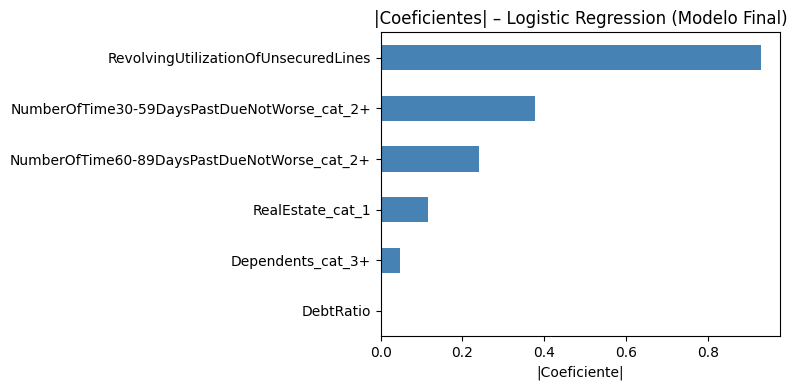

In [23]:
# Coeficientes del modelo
coefs = pd.Series(np.abs(best_model.coef_[0]), index=BEST_FEATURES).sort_values()

fig, ax = plt.subplots(figsize=(8, 4))
coefs.plot(kind='barh', ax=ax, color='steelblue')
ax.set_title('|Coeficientes| – Logistic Regression (Modelo Final)')
ax.set_xlabel('|Coeficiente|')
plt.tight_layout()
plt.show()

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.